In [243]:
import numpy as np
import pandas as pd
import re
import nltk
import string
from collections import defaultdict

from tqdm.notebook import tqdm

from scipy.sparse import csr_matrix, hstack

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

from modules.linear_model import LinearModel
from modules.losses import BinaryLogisticLoss

import matplotlib.pyplot as plt

In [183]:
train_data = pd.read_csv('toxic_train_test_data/train.csv')
test_data = pd.read_csv('toxic_train_test_data/test.csv')

In [184]:
train_data.head()

,comment_text,is_toxic,toxic_level,insult,obscene,obscene_and_insult,no_obscene_no_insult
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [185]:
test_data.head()

,comment_text,is_toxic,toxic_level,insult,obscene,obscene_and_insult,no_obscene_no_insult
0,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,:Dear god this site is horrible.,0,0,0,0,0,0
2,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [186]:
def preprocess(data):
    data = data[['comment_text', 'is_toxic']]
    tokenizer = nltk.WordPunctTokenizer()
    data['comment_text'] = \
        data['comment_text'].apply(lambda x: tokenizer.tokenize(x.lower()))
    data['comment_text'] = \
        data['comment_text'].apply(
        lambda x: [w for w in x if all(c not in string.punctuation for c in w) and len(w) > 2]
    )
    data['comment_text'] = \
        data['comment_text'].apply(lambda x: [w for w in x if not w.isdigit()])
    data['comment_text'] = data['comment_text'].apply(lambda x: ' '.join(x))

    return data['comment_text'], data['is_toxic']

In [1]:
X_train, y_train = preprocess(train_data)

In [194]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

In [2]:
X_test, y_test = preprocess(test_data)

In [197]:
tf = TfidfVectorizer(min_df=0.05, max_features=3000)

In [199]:
X_train = tf.fit_transform(X_train)
X_val, X_test = tf.transform(X_val), tf.transform(X_test)

In [202]:
X_train = csr_matrix(hstack([csr_matrix(np.ones((X_train.shape[0], 1))), X_train]))
X_val = csr_matrix(hstack([csr_matrix(np.ones((X_val.shape[0], 1))), X_val]))
X_test = csr_matrix(hstack([csr_matrix(np.ones((X_test.shape[0], 1))), X_test]))

y_train = 2 * y_train.values - 1
y_val = 2 * y_val.values - 1
y_test = 2 * y_test.values - 1

In [297]:
alpha_list = np.logspace(0, -3, 10)
beta_list = [0, 0.1, 0.2, 0.5, 1, 2, 5]

In [298]:
history = defaultdict(dict)
accs = defaultdict(dict)

In [299]:
for alpha in tqdm(alpha_list):
    for beta in beta_list:
        loss = BinaryLogisticLoss(l2_coef=0)
        clf = LinearModel(loss, max_iter=100, step_alpha=alpha, step_beta=beta)
        history[alpha][beta] = clf.fit(
            X_train, y_train, X_val=X_val, y_val=y_val, trace=True
        )
        preds = clf.predict(X_val)
        accs[alpha][beta] = balanced_accuracy_score(y_val, preds)

In [300]:
acc_max = 0

for alpha in tqdm(alpha_list):
    for beta in beta_list:
        if accs[alpha][beta] > acc_max:
            acc_max = accs[alpha][beta]
            alpha_max = alpha
            beta_max = beta

In [301]:
acc_max, alpha_max, beta_max

(0.7053918752429964, 1.0, 0)

In [302]:
acc_min = 1

for alpha in tqdm(alpha_list):
    for beta in beta_list:
        if accs[alpha][beta] < acc_min:
            acc_min = accs[alpha][beta]
            alpha_min = alpha
            beta_min = beta

In [303]:
acc_min, alpha_min, beta_min

(0.49881762345954284, 0.1, 5)

In [309]:
len_best = len(history[alpha_max][beta_max]['func'])
len_worst = len(history[alpha_min][beta_min]['func'])

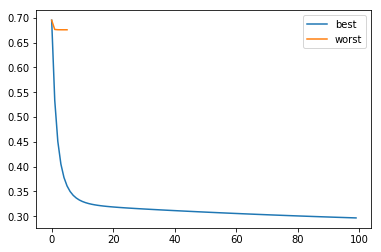

In [310]:
plt.plot(np.arange(len_best), history[alpha_max][beta_max]['func'], label='best')
plt.plot(np.arange(len_worst), history[alpha_min][beta_min]['func'], label='worst')
plt.legend();

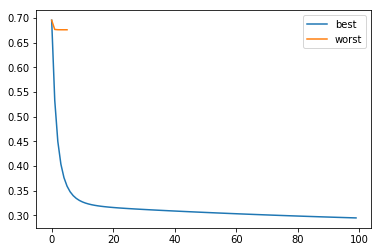

In [311]:
plt.plot(np.arange(len_best), history[alpha_max][beta_max]['func_val'], label='best')
plt.plot(np.arange(len_worst), history[alpha_min][beta_min]['func_val'], label='worst')
plt.legend();

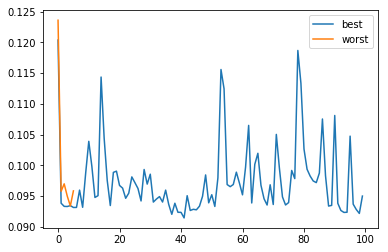

In [312]:
plt.plot(np.arange(len_best), history[alpha_max][beta_max]['time'], label='best')
plt.plot(np.arange(len_worst), history[alpha_min][beta_min]['time'], label='worst')
plt.legend();

In [313]:
batch_size_list = [256, 1024, 4096, 16384, 65536]

In [314]:
history = defaultdict(lambda: defaultdict(dict))
accs = defaultdict(lambda: defaultdict(dict))

In [315]:
for b_size in tqdm(batch_size_list):
    for alpha in alpha_list:
        for beta in beta_list:
            loss = BinaryLogisticLoss(l2_coef=0)
            clf = LinearModel(
                loss, max_iter=100, batch_size=b_size,
                step_alpha=alpha, step_beta=beta
            )
            history[b_size][alpha][beta] = clf.fit(
                X_train, y_train, X_val=X_val, y_val=y_val, trace=True
            )
            preds = clf.predict(X_val)
            accs[b_size][alpha][beta] = balanced_accuracy_score(y_val, preds)

In [316]:
acc_max = 0

for b_size in batch_size_list:
    for alpha in alpha_list:
        for beta in beta_list:
            if accs[b_size][alpha][beta] > acc_max:
                acc_max = accs[b_size][alpha][beta]
                alpha_max = alpha
                beta_max = beta
                bs_max = b_size

In [317]:
acc_max, alpha_max, beta_max, bs_max

(0.7083030444480223, 1.0, 0, 1024)

In [318]:
len_best = len(history[bs_max][alpha_max][beta_max]['func'])

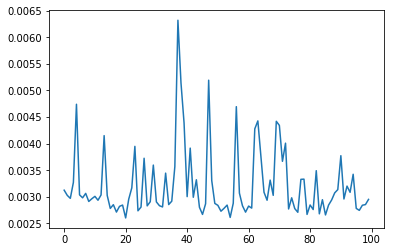

In [321]:
plt.plot(np.arange(len_best), history[bs_max][alpha_max][beta_max]['time'], label='best')

In [323]:
clf = LinearModel(
                loss, max_iter=100, batch_size=bs_max,
                step_alpha=alpha_max, step_beta=beta_max
            )

In [324]:
clf.fit(X_train, y_train, X_val=X_val, y_val=y_val, trace=False)

defaultdict(list, {})

In [325]:
balanced_accuracy_score(y_test, clf.predict(X_test))

0.667023834686535